# Pricing Exotic Options with TensorFlow and calculate greeks using Automatic Differentiation

*by Matthias Groncki (2018) matthias.groncki [at] gmail [dot] com*

During writing my previous <a href="https://ipythonquant.wordpress.com/2018/05/18/from-logistic-regression-in-scikit-learn-to-deep-learning-with-tensorflow-a-fraud-detection-case-study-part-ii/" target="_blank">post</a> about fraud detection with logistic regression with TensorFlow and gradient descent methods I had the idea to use TensorFlow for the pricing of path dependent exotic options. TensorFlow uses automatic (algorithmic) differentitation (AD) to calculate the gradients of the computational graph. So if we implement a closed pricing formula in TensorFlow we should get the greeks for 'free'. With 'free' I mean without implementing  a closed formula (if avialable) or without implementing a numerical method (like finite difference) to calculate the greeks. In Theory the automatic differentiation should be a bit times slower then just the pricing but the cost should be independent on the number of greeks we calculate.

Monte Carlo Simulations can benefit of AD a lot, when each pricing is computational costly (simulation) and we have many risk drivers, the calculation of greeks become very challenging. Imagine a interest rate derivate and we want to calculate the delta and gamma and mixed gammas for each pillar on the yield curve, if we use bump-and-revaluate to calculate the greeks we need many revaluations.

For simplicty we focus on equity options in a Black-Scholes model world since I want to focus on the numerical implementation in TensorFLow. Today we will look into the Monte-Carlo pricing of Plain Vanilla Options,  Geometric Asian Options and Down-And-Out Barriers. All options in this post are Calls. For a introduction into TensorFlow look into my previous post on Logisitc Regression in TensorFlow.

## Plain Vanilla Call

Lets start with a plain vanilla Call. Let me give a brief introduction into options for the non-quant readers, if you familiar with options skip this part and go directly to the implementation.

A call gives us the right to buy a unit of a underlying (e.g Stock) at preagreed price (strike) at a future time (option maturity), regardless of the actual price at that time.So the value  the Call at option maturity is

$$  C = \max(S_T-K,0),$$

with $S_T$ the price of the underlying at option maturity $T$ and strike $K$. Clearly we wouldn't exercise the option if the actual price is below the strike, so its worthless (out of the money).

Its very easy to calculate the price of the option at maturity but we are more interested into the todays price before maturity.

Black, Scholes and Merton had a very great idea how to tackle the problem (Nobel prize worth idea), and come up with a closed pricing formula.

We will first implement the closed formula and then implement the pricing with a Monte Carlo Simulation. 

Not for all kind of options and models we have analytical formula to get the price. A very generic method to price options is the Monte-Carlo Simulation. The basic idea is to simulated many possible (random) evolutions (outcomes/realizations) of the underlying price (paths) and price the option of each of these paths and approximate the price with the average of the simulated option prices. Depending on the underlying stochastic process for the underyling in the model we need numerical approximations for the paths.

For a more detailed introduction into derivates have a look into the book 'Futures, Forward and other derivates' from Prof. John Hull.

We lets assume the current stock price is 100, the strike is 110 and maturity is in 2 years from now. The current risk free interest rate is 3% and the implied market vol is 20%.

In [1]:
import numpy as np
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## Plain Vanilla Call in TensorFlow

def blackScholes_py(S_0, strike, time_to_expiry, implied_vol, riskfree_rate):
    S = S_0
    K = strike
    dt = time_to_expiry
    sigma = implied_vol
    r = riskfree_rate
    Phi = stats.norm.cdf
    d_1 = (np.log(S_0 / K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d_2 = d_1 - sigma*np.sqrt(dt)
    return S*Phi(d_1) - K*np.exp(-r*dt)*Phi(d_2)


In [3]:
blackScholes_py(100., 110., 2., 0.2, 0.03)

9.73983632580859

In [4]:
%timeit blackScholes_py(100., 110., 2., 0.2, 0.03)

156 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


The todays price is 9.73 and a pricing with the closed formula is super fast less then 200 mirco seconds.

Now lets implement the same pricing formula in TensorFLow. We use the concept of a function closure. The outer function constructs the static TensorFow graph, and the inner function (which we return) let us feed in our parameters into the graph and execute it and return the results.

In [5]:
def blackScholes_tf_pricer(enable_greeks = True):
    # Build the static computational graph
    S = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    Phi = tf.distributions.Normal(0.,1.).cdf
    d_1 = (tf.log(S / K) + (r+sigma**2/2)*dt) / (sigma*tf.sqrt(dt))
    d_2 = d_1 - sigma*tf.sqrt(dt)
    npv =  S*Phi(d_1) - K*tf.exp(-r*dt)*Phi(d_2)
    target_calc = [npv]
    if enable_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, dt])
        dS_2ndOrder = tf.gradients(greeks[0], [S, sigma, r, K, dt]) 
        # Calculate mixed 2nd order greeks for S (esp. gamma, vanna) and sigma (esp. volga)
        dsigma_2ndOrder = tf.gradients(greeks[1], [S, sigma, r, K, dt])
        dr_2ndOrder = tf.gradients(greeks[2], [S, sigma, r, K, dt]) 
        dK_2ndOrder = tf.gradients(greeks[3], [S, sigma, r, K, dt]) 
        dT_2ndOrder = tf.gradients(greeks[4], [S, sigma, r, K, dt])
        target_calc += [greeks, dS_2ndOrder, dsigma_2ndOrder, dr_2ndOrder, dK_2ndOrder, dT_2ndOrder]
    
    # Function to feed in the input and calculate the computational graph
    def execute_graph(S_0, strike, time_to_expiry, implied_vol, riskfree_rate):
        with tf.Session() as sess:
            res = sess.run(target_calc, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt: time_to_expiry})
        return res
    return execute_graph
        
    

In [6]:
tf_pricer = blackScholes_tf_pricer()
tf_pricer(100., 110., 2., 0.2, 0.03)

[9.739834,
 [0.5066145, 56.411205, 81.843216, -0.37201464, 4.0482087],
 [0.014102802, 0.5310427, 2.8205605, -0.012820729, 0.068860546],
 [0.5310427, -1.2452297, -6.613867, 0.030063031, 13.941332],
 [2.8205605, -6.613866, 400.42563, -1.8201164, 46.5973],
 [-0.012820728, 0.030063028, -1.8201163, 0.011655207, -0.025798593],
 [0.06886053, 13.941331, 46.597298, -0.025798589, -0.62807804]]

In [7]:
tf_pricer = blackScholes_tf_pricer(True)
%timeit tf_pricer(100., 110., 2., 0.2, 0.03)

2.32 s ± 304 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
tf_pricer = blackScholes_tf_pricer(False)
%timeit tf_pricer(100., 110., 2., 0.2, 0.03)

269 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We calculated 30 different greeks and one npv, so for a bump and revaluation we would need 31 times the time for one pricing. So that definetly a speed up but compare to the 'pure' python implementation is awefully slow. But its easy to implement and reduce maybe developing time.

### Monte Carlo Simulation with TensorFlow

In the Black Scholes model the underlying price follows a geometric Brownian motion and we now the distribution of the prices in the futures given the current price, the risk free interest rate and the implied volatiliy of the underlying. So we are able to sample future prices directly.

We use a helper function `create_tf_graph_for_simulate_paths` which build a computational graph in TensorFlow to calculate the future prices given the required inputs and normal distributed random variables `dw` with mean zero and a standard deviation of one. The function will return the operator to calculate the random price paths and the placeholder we need to feed in our parameter.

We assume we need to calculate the prices at equidistant points of time. The column of the random matrix `dw` defines the number of time on each path and the rows the numbers of different paths. 

For example a random matrix with the shape (1000, 10) would have 1000 path with the prices of the underlying at times T/10, 2T/10, ... T.

In [44]:
def create_tf_graph_for_simulate_paths():
    S = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    T = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    dw = tf.placeholder(tf.float32)
    S_T = S * tf.cumprod(tf.exp((r-sigma**2/2)*dt+sigma*tf.sqrt(dt)*dw), axis=1)
    return (S, K, dt, T, sigma, r, dw, S_T)

To test the function we create another function which use the function above to create the computational graph and returns another function which feed our parametrization into the graph and run it and return the simulated paths.

In [10]:
def make_path_simulator():
    (S,K, dt, T, sigma, r, dw, S_T) = create_tf_graph_for_simulate_paths()
    def paths(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, seed, n_sims, obs):
        if seed != 0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, obs)
        with tf.Session() as sess:
            timedelta = time_to_expiry / stdnorm_random_variates.shape[1]
            res = sess.run(S_T, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt : timedelta,
                               T: time_to_expiry,
                               dw : stdnorm_random_variates
                         })
            return res
    return paths

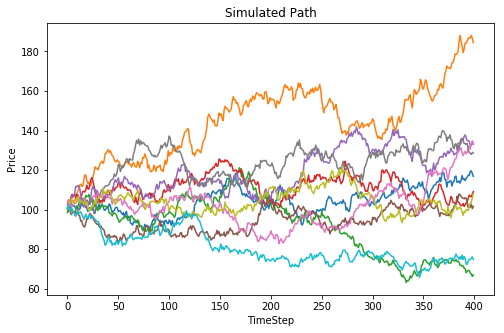

In [11]:
path_simulator = make_path_simulator()
paths = path_simulator(100, 110.,  2, 0.2, 0.03, 1312, 10, 400)
plt.figure(figsize=(8,5))
_= plt.plot(np.transpose(paths))
_ = plt.title('Simulated Path')
_ = plt.ylabel('Price')
_ = plt.xlabel('TimeStep') 

In [12]:
# Test if the expected value of the simulated prices fit is close to the expected mean 
path_simulator = make_path_simulator()
paths = path_simulator(100, 110.,  2, 0.2, 0.03, 1312, 10000000, 2)
assert(np.mean(paths[:, 1])-np.exp(0.03*2)*100<0.01)

Now we going to price our plain vanilla call. We will use the same design pattern as above (function clousure). The function will create the computational graph and returns a function that generates the random numbers, feed our parameter into the graph and run it.

Actually we just extend the previous function with the pricing of the call on the path `payout = tf.maximum(S_T[:,-1] - K, 0)` and we discount it and we add some extra lines to calculate the greeks.

In [13]:
def create_plain_vanilla_mc_tf_pricer(enable_greeks = True):
    (S,K, dt, T, sigma, r, dw, S_T) = create_tf_graph_for_simulate_paths()
    payout = tf.maximum(S_T[:,-1] - K, 0)
    npv = tf.exp(-r*T) * tf.reduce_mean(payout)
    target_calc = [npv]
    if enable_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, T])
        target_calc += [greeks]
    def pricer(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, seed, n_sims):
        if seed != 0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, 1)
        with tf.Session() as sess:
            timedelta = time_to_expiry / stdnorm_random_variates.shape[1]
            res = sess.run(target_calc, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt : timedelta,
                               T: time_to_expiry,
                               dw : stdnorm_random_variates
                         })
            return res
    return pricer

In [14]:
plain_vanilla_mc_tf_pricer = create_plain_vanilla_mc_tf_pricer()
plain_vanilla_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 1000000)

[9.734369, [0.5059894, 56.38598, 81.72916, -0.37147698, -0.29203108]]

In [15]:
%%timeit
plain_vanilla_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 1000000)

392 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
plain_vanilla_mc_tf_pricer = create_plain_vanilla_mc_tf_pricer(False)
%timeit plain_vanilla_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 1000000)


336 ms ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
plain_vanilla_mc_tf_pricer = create_plain_vanilla_mc_tf_pricer(False)
plain_vanilla_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 1000000)

[9.734369]

The MC pricing is faster then the analytical solution in TensorFlow (ok we only have first order derivates) and the
extra costs for the greeks is neglectable.

Lets try some exotic (path dependent) options.

## Exotic path dependent option

### Asian Options

The fair value of a Asian option depends not only on the price  of the underlying at option maturity but also on the values during the lifetime to predefined times. A Asian Call pay the difference between the average price and the strike or nothing. 

A  asian option which use the geometric mean of the underlying is also called Geometric Asian Option.

We follow the previous design we only make some extensions to the payoff and pricing method (need number of observation points).

In [18]:
def create_geometric_asian_mc_tf_pricer(enable_greeks = True):
    (S,K, dt, T, sigma, r, dw, S_T) = create_tf_graph_for_simulate_paths()
    A = tf.pow(tf.reduce_prod(S_T, axis=1),dt/T)
    payout = tf.maximum(A - K, 0)
    npv = tf.exp(-r*T) * tf.reduce_mean(payout)
    target_calc = [npv]
    if enable_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, T])
        target_calc += [greeks]
    def pricer(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, seed, n_sims, obs):
        if seed != 0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, obs)
        with tf.Session() as sess:
            timedelta = time_to_expiry / obs
            res = sess.run(target_calc, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt : timedelta,
                               T: time_to_expiry,
                               dw : stdnorm_random_variates
                         })
            return res
    return pricer

Lets assume we have an option which expiries in two years with a strike of 110 and 8 observations points (quarterly observed).

In [19]:
geom_asian_mc_tf_pricer = create_geometric_asian_mc_tf_pricer()
geom_asian_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 100000, 8)

[4.196899, [0.3719058, 30.388206, 33.445602, -0.29993924, -89.84526]]

In [20]:
%%timeit
geom_asian_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 100000, 8)

471 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
geom_asian_mc_tf_pricer = create_geometric_asian_mc_tf_pricer(False)
geom_asian_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 100000, 8)

[4.196899]

In [22]:
%timeit geom_asian_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 100000, 8)

319 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Again the extra cost for the derivates is very low.

### Down and Out Options

Now lets try a down and out call. A down-and-out Call behaves as a normal Call but if the price of the underlying touch or fall below a certain level (the barrier B) at any time until the expiry the option, then it becomes worthless, even if its at expiry in the money.

A down and out call is cheaper than the plain vanilla case, since there is a risk that the option get knocked out before reaching the expiry. It can be used to reduce the hedging costs.

In the Black-Scholes model there is again a closed formula to calculate the price. See https://people.maths.ox.ac.uk/howison/barriers.pdf or https://warwick.ac.uk/fac/soc/wbs/subjects/finance/research/wpaperseries/1994/94-54.pdf .

We want to price this kind of option in TensorFlow with a Monte-Carlo Simulation and let TensorFLow calculate the path derivates with automatic differentitation.

Because of the nature of the product it quite difficult to calculate the npv and greeks in a Monte-Carlo Simulation. Obviously we have a bias in our price since we  check if the barrier hold on discrete timepoints while the barrier has to hold in continous time. The closer we get to the Barrier the more off we will be from the analytical price and greeks. The MC price will tend to overestimate the value of the option. See the slides from Mike Giles about Smoking adjoints (automtic differentiation) https://people.maths.ox.ac.uk/gilesm/talks/quant08.pdf. 

First we implement the analytical solutions in 'pure' Python (actually we rely heavly on numpy) and in TensorFLow.

In [23]:
def analytical_downOut_py(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, barrier):
    S = S_0
    K = strike
    dt = time_to_expiry
    sigma = implied_vol
    r = riskfree_rate
    alpha = 0.5 - r/sigma**2
    B = barrier
    Phi = stats.norm.cdf
    d_1 = (np.log(S_0 / K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d_2 = d_1 - sigma*np.sqrt(dt)
    bs = S*Phi(d_1) - K*np.exp(-r*dt)*Phi(d_2)
    d_1a = (np.log(B**2 / (S*K)) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d_2a = d_1a - sigma*np.sqrt(dt)
    reflection = (S/B)**(1-r/sigma**2) * ((B**2/S)*Phi(d_1a) - K*np.exp(-r*dt)*Phi(d_2a))
    return max(bs - reflection,0)



def analytical_downOut_tf_pricer(enable_greeks = True):
    S = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    B = tf.placeholder(tf.float32)
    Phi = tf.distributions.Normal(0.,1.).cdf
    d_1 = (tf.log(S / K) + (r+sigma**2/2)*dt) / (sigma*tf.sqrt(dt))
    d_2 = d_1 - sigma*tf.sqrt(dt)
    bs_npv =  S*Phi(d_1) - K*tf.exp(-r*dt)*Phi(d_2)
    d_1a = (tf.log(B**2 / (S*K)) + (r+sigma**2/2)*dt) / (sigma*tf.sqrt(dt))
    d_2a = d_1a - sigma*tf.sqrt(dt)
    reflection = (S/B)**(1-r/sigma**2) * ((B**2/S)*Phi(d_1a) - K*tf.exp(-r*dt)*Phi(d_2a))
    npv = bs_npv - reflection
    target_calc = [npv]
    if enable_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, dt, B])
        # Calculate mixed 2nd order greeks for S (esp. gamma, vanna) and sigma (esp. volga)
        dS_2ndOrder = tf.gradients(greeks[0], [S, sigma, r, K, dt, B]) 
        #dsigma_2ndOrder = tf.gradients(greeks[1], [S, sigma, r, K, dt, B]) 
        # Function to feed in the input and calculate the computational graph
        target_calc += [greeks, dS_2ndOrder]
    def price(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, barrier):
        """
        Returns the npv, delta, vega and gamma
        """
        with tf.Session() as sess:
            
            res = sess.run(target_calc, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt: time_to_expiry,
                               B : barrier})
        if enable_greeks:
            return np.array([res[0], res[1][0], res[1][1], res[2][0]])
        else:
            return res
    return price

In [24]:
analytical_downOut_py(100., 110., 2., 0.2, 0.03, 80)

9.300732987604157

In [25]:
%timeit analytical_downOut_py(100., 110., 2., 0.2, 0.03, 80.)

344 µs ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
down_out_pricer = analytical_downOut_tf_pricer(True)

In [27]:
down_out_pricer(100., 110., 2., 0.2, 0.03, 80.)

array([9.3007298e+00, 5.4559779e-01, 4.4391003e+01, 1.0688490e-02],
      dtype=float32)

In [28]:
down_out_pricer = analytical_downOut_tf_pricer(False)
%timeit down_out_pricer(100., 110., 2., 0.2, 0.03, 80.)

393 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
down_out_pricer = analytical_downOut_tf_pricer(True)
%timeit down_out_pricer(100., 110., 2., 0.2, 0.03, 80.)

1.63 s ± 80.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The Tensorflow implementation is much slower than the one in Python. Lets visualize the fair values depending of the barrier.

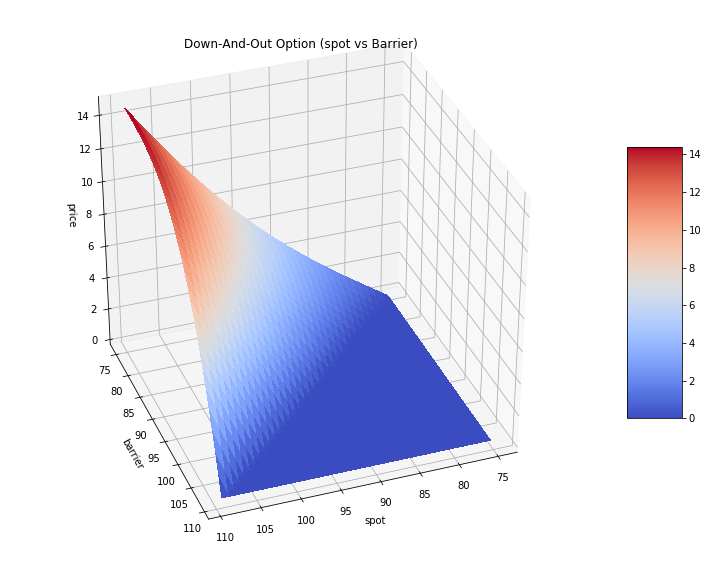

In [30]:
def surface_plt(X,Y,Z, name='', angle=70):
    fig = plt.figure(figsize=(13,10))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title('Down-And-Out Option (%s vs Barrier)' % name)
    ax.view_init(35, angle)
    ax.set_xlabel(name)
    ax.set_ylabel('barrier')
    ax.set_zlabel('price')
    plt.savefig('npv_%s_barrier.png' % name, dpi=300)
    

T = np.arange(0.01, 2, 0.1)
S = np.arange(75, 110, 1)
V = np.arange(0.1, 0.5, 0.01)
B = np.arange(75, 110, 1)
X, Y = np.meshgrid(S, B)
vectorized_do_pricer = np.vectorize(lambda s,b : analytical_downOut_py(s, 110., 2, 0.2, 0.03, b))
Z = vectorized_do_pricer(X, Y)
surface_plt(X,Y,Z,'spot', 70)

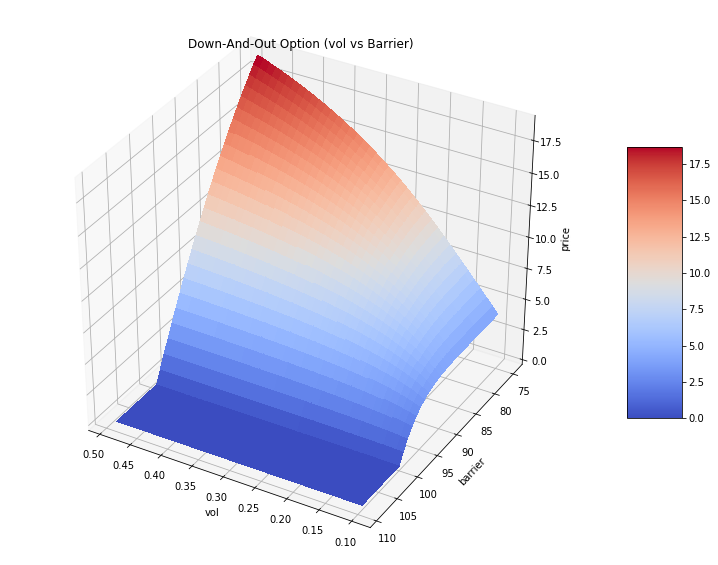

In [31]:
X, Y = np.meshgrid(V, B)
vectorized_do_pricer = np.vectorize(lambda x,y : analytical_downOut_py(100, 110., 2, x, 0.03, y))
Z = vectorized_do_pricer(X, Y)
surface_plt(X,Y,Z,'vol', 120)

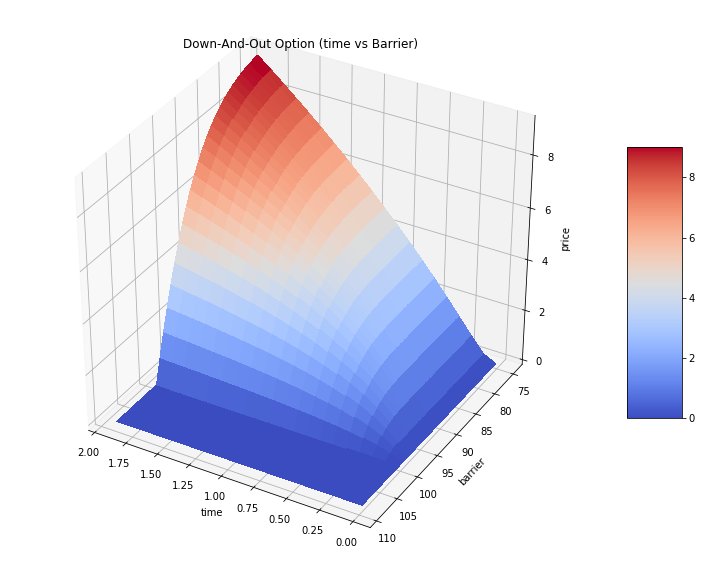

In [32]:
X, Y = np.meshgrid(T, B)
vectorized_do_pricer = np.vectorize(lambda x,y : analytical_downOut_py(100, 110., x, 0.2, 0.03, y))
Z = vectorized_do_pricer(X, Y)
surface_plt(X,Y,Z,'time', 120)

Now lets implement the Monte Carlo Pricing. First as pure python version.

In [33]:
def monte_carlo_down_out_py(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, barrier, seed, n_sims, obs):
    if seed != 0:
            np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(n_sims, obs)
    S = S_0
    K = strike
    dt = time_to_expiry / stdnorm_random_variates.shape[1]
    sigma = implied_vol
    r = riskfree_rate
    B = barrier
    # See Advanced Monte Carlo methods for barrier and related exotic options by Emmanuel Gobet
    B_shift = B*np.exp(0.5826*sigma*np.sqrt(dt))
    S_T = S * np.cumprod(np.exp((r-sigma**2/2)*dt+sigma*np.sqrt(dt)*stdnorm_random_variates), axis=1)
    non_touch = (np.min(S_T, axis=1) > B_shift)*1
    call_payout = np.maximum(S_T[:,-1] - K, 0)
    npv = np.mean(non_touch * call_payout)
    return np.exp(-time_to_expiry*r)*npv

In [34]:
monte_carlo_down_out_py(100., 110., 2., 0.2, 0.03, 80., 1312, 10000, 500)

9.34385678328728

In [35]:
%%timeit
monte_carlo_down_out_py(100., 110., 2., 0.2, 0.03, 80., 1312, 10000, 500)

211 ms ± 8.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now now as TensorFlow version. 

In [36]:
def create_downout_mc_tf_pricer(enable_greeks = True):
    (S,K, dt, T, sigma, r, dw, S_T) = create_tf_graph_for_simulate_paths()
    B = tf.placeholder(tf.float32)
    B_shift = B * tf.exp(0.5826*sigma*tf.sqrt(dt))
    non_touch = tf.cast(tf.reduce_all(S_T > B_shift, axis=1), tf.float32)
    payout = non_touch * tf.maximum(S_T[:,-1] - K, 0)
    npv = tf.exp(-r*T) * tf.reduce_mean(payout)
    target_calc = [npv]
    if enable_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, T])
        target_calc += [greeks]
    def pricer(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, barrier, seed, n_sims, obs):
        if seed != 0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, obs)
        with tf.Session() as sess:
            timedelta = time_to_expiry / obs
            res = sess.run(target_calc, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt : timedelta,
                               T: time_to_expiry,
                               B: barrier,
                               dw : stdnorm_random_variates
                         })
            return res
    return pricer




In [37]:
downout_mc_tf_pricer = create_downout_mc_tf_pricer()
downout_mc_tf_pricer(100., 110., 2., 0.2, 0.03, 80., 1312, 10000, 500)

[9.34386, [0.47031397, 54.249084, 75.3748, -0.34261367, -0.2803158]]

In [38]:
%timeit downout_mc_tf_pricer(100., 110., 2., 0.2, 0.03, 80., 1312, 10000, 500)

886 ms ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
downout_mc_tf_pricer = create_downout_mc_tf_pricer(False)
downout_mc_tf_pricer(100., 110., 2., 0.2, 0.03, 80., 1312, 10000, 500)

[9.34386]

In [40]:
%timeit downout_mc_tf_pricer(100., 110., 2., 0.2, 0.03, 80., 1312, 10000, 500)

710 ms ± 78.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Lets compare the root mean square error depending on the barrier. This code runs a bit longer.

In [41]:
downout_mc_tf_pricer = create_downout_mc_tf_pricer(True)
barriers = [70., 75., 85., 90., 95., 99.]
se_npv = np.zeros((6, 30))
se_delta = np.zeros((6, 30))
for i in range(len(barriers)):
    b = barriers[i]
    analytic_solution = down_out_pricer(100., 110., 2., 0.2, 0.03, b)
    for j in range(30):
        res = downout_mc_tf_pricer(100., 110., 2., 0.2, 0.03, b, 0, 10000, 500)
        se_npv[i,j] = (res[0]-analytic_solution[0])**2
        se_delta[i,j] = (res[1][0]-analytic_solution[1])**2
rmse_npv = np.sqrt(np.mean(se_npv, axis=1))
rmse_delta = np.sqrt(np.mean(se_delta, axis=1))

In [42]:
rmse_npv

array([0.18176392, 0.18669612, 0.24179155, 0.30743509, 0.27624987,
       0.17070715])

In [43]:
rmse_delta

array([0.00778352, 0.02296957, 0.18031364, 0.36479934, 0.63877604,
       0.91119511])

The pure Python MC needs 211 ms ± 8.95 ms per npv vs the 886 ms ± 23.4 ms per loop for the TensorFlow MC with 5 greeks. So its not that bad as the performance for the closed formula implementation suggests.

There are many things we could try now: implementing other options, try different models (processes), implement a discretisation scheme to solve a stochastic process numerically in TensorFlow, try to improve the Barrier option with more advanced Monte Carlo techniques (Brownian Bridge). But that's it for now. 

For me it was quite fun to implement the Monte Carlo Simulations and do some simple pricing in TensorFlow. For me it was very suprising and unexpected that the analytical implementations are so slow compared to pure Python. Therefore the Monte Carlo Simulation in TensorFlow seems quite fast. Maybe the bad performance for the closed formula pricings is due to my coding skills. 

Nevertheless TensorFlow offers a easy to use auto grad (greeks) feature and the extra cost in a MC Simulation is neglectiable and the automatic differentiation is faster than DF when we need to calculate more than 4-6 greeks. And in some cases we can be with 5 greeks as fast as pure Python as seen the barrier sample.  (approx 1 sec for a Tensorflow (npv and 5 greeks) vs 200 ms for Python (single npv). So i assume we can be faster compared to a pure Python implementation when we need to calculate many greeks (pillars on a yield curve or vol surface).